In [1]:
!pip install -r requirements.txt

  Using cached pandas-2.3.3-cp39-cp39-macosx_11_0_arm64.whl (10.8 MB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
     |████████████████████████████████| 294 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 250 kB 8.3 MB/s eta 0:00:01
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl (348 kB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl (249 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl (64 kB)
     |████████████████████████████████| 122 kB 49.7 MB/s eta 0:00:01
  Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fonttools-4.60.2-cp39-cp39-macosx_10_9_universal2.whl (2.9 MB)
  Using cached pillow-11.3.0-cp39-cp39-macosx_11_0_arm6

In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('OnlineRetail.csv', encoding='latin-1') #file contains currency symbols
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [ ]:
# creating sqlite database
conn = sqlite3.connect('online_retail.db')
data.to_sql(
    name='online_retail',
    con=conn,
    if_exists='replace',
    index=False
) #541909 rows have been added to database
conn.close()

In [8]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [38]:
#splitting dataset into 3 thematic databases
conn = sqlite3.connect('online_retail.db')

stocks = pd.read_sql("""
    SELECT StockCode, UnitPrice, Description
    FROM online_retail
    WHERE CustomerID IS NOT NULL;                                     
""", conn)

users = pd.read_sql("""
    SELECT CustomerID, Country
    FROM online_retail
    WHERE CustomerID IS NOT NULL;                    
""", conn)

orders = pd.read_sql("""
    SELECT InvoiceNo, InvoiceDate, Quantity,
         StockCode, CustomerID,
        CASE 
            WHEN CustomerID IS NULL THEN 'yes'
            ELSE 'no'
        END AS is_anonymous
    FROM online_retail;
""", conn)


orders['InvoiceDate'] = pd.to_datetime(orders.InvoiceDate, errors='coerce', dayfirst=False)
orders['year_month'] = orders.InvoiceDate.dt.to_period('M')
orders['MonthNumber'] = orders['year_month'].factorize()[0] + 1
if 'year_month' in orders:
    orders = orders.drop('year_month', axis=1)
orders.to_sql('orders', conn, if_exists='replace', index=False)

stocks.to_sql('stocks', conn, if_exists='replace', index=False)
users.to_sql('users', conn, if_exists='replace', index=False)

conn.close()


In [ ]:
#DAU & MAU. Conclusion №1

conn = sqlite3.connect('online_retail.db')

with open('sql/dau.sql', 'r') as file:
    dau_query = file.read()
with open('sql/mau.sql') as file:
    mau_query = file.read()


dau = pd.read_sql(dau_query, conn)
mau = pd.read_sql(mau_query, conn)

dau.head()

,MonthNumber,date_day,dau
0,1,2010-12-01,98
1,1,2010-12-02,117
2,1,2010-12-03,55
3,1,2010-12-05,76
4,1,2010-12-06,90


In [49]:
mau.tail(20)

,MonthNumber,mau
0,1,948
1,2,783
2,3,798
3,4,1020
4,5,899
5,6,1079
6,7,1051
7,8,993
8,9,980
9,10,1302


In [50]:
dau_month_avg = (
    dau
    .groupby('MonthNumber', as_index=False)['dau']
    .mean()
    .rename(columns={'dau': 'avg_dau'}))

stickiness_df = dau_month_avg.merge(
    mau,
    on='MonthNumber',
    how='inner')

stickiness_df['stickiness'] = stickiness_df['avg_dau'] / stickiness_df['mau']
stickiness_df.head(2)

,MonthNumber,avg_dau,mau,stickiness
0,1,70.15,948,0.073998
1,2,46.50,783,0.059387


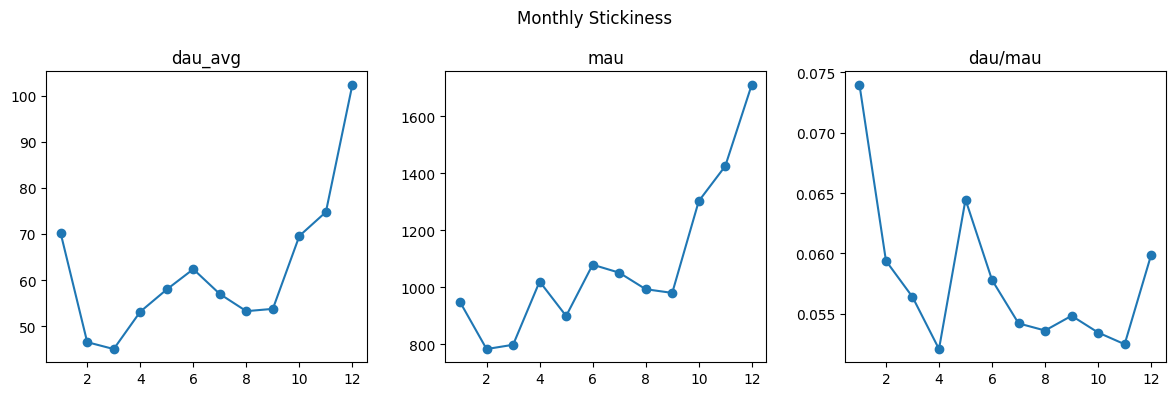

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
#last month is not whole
axes[0].plot(stickiness_df.MonthNumber[:-1], stickiness_df.avg_dau[:-1], marker='o')
axes[1].plot(stickiness_df.MonthNumber[:-1], stickiness_df.mau[:-1], marker='o')
axes[2].plot(stickiness_df.MonthNumber[:-1], stickiness_df.stickiness[:-1], marker='o')

axes[0].set_title('dau_avg')
axes[1].set_title('mau')
axes[2].set_title('dau/mau')

plt.suptitle('Monthly Stickiness')
plt.tight_layout()

In [ ]:
# Interval Retention - conclusion №2
def retention_ab_interval(interval, conn):
    a, b = interval
    with open('sql/interval_retention.sql') as f:
        query = f.read().replace('*7', str(a)).replace('*14', str(b))
        return pd.read_sql(query, conn).iloc[0, 0]

conn = sqlite3.connect('online_retail.db')
intervals_part = [(x, x+7) for x in range (0, 93, 7)]
intervals_part[0] = (1, 7)
intervals_full = [(1, y) for y in range(7, 100, 7)]  
retentions_part = {}
retentions_full = {}

for inter in intervals_part:
    retentions_part[f'{inter[1]}'] = retention_ab_interval(inter, conn)
for inter in intervals_full:
    retentions_full[f'{inter[1]}'] = retention_ab_interval(inter, conn)

conn.close()

In [5]:
df_retention_part = pd.DataFrame(list(retentions_part.items()), columns=['interval', 'retention'])
df_retention_full = pd.DataFrame(list(retentions_full.items()), columns=['interval', 'retention'])

df_retention_part.head()

,interval,retention
0,7,0.121683
1,14,0.119167
2,21,0.081656
3,28,0.073651
4,35,0.089204


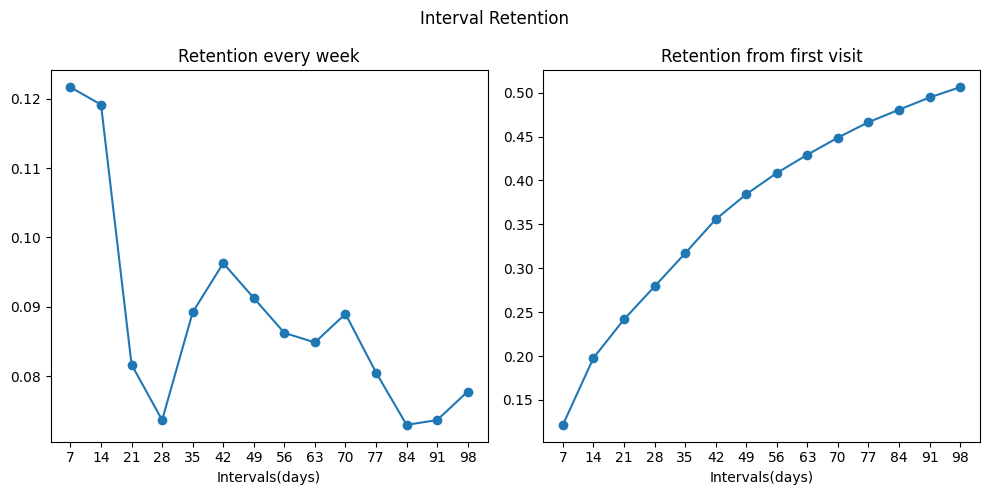

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(df_retention_part.interval, df_retention_part.retention, marker='o')
axes[1].plot(df_retention_full.interval, df_retention_full.retention, marker='o')

axes[0].set_title('Retention every week')
axes[1].set_title('Retention from first visit')
axes[0].set_xlabel('Intervals(days)')
axes[1].set_xlabel('Intervals(days)')

plt.suptitle('Interval Retention')
plt.tight_layout()

In [11]:
# ARPU - for month and LTV

conn = sqlite3.connect('online_retail.db')

with open('sql/arpu.sql', 'r') as file:
    query_arpu = file.read()
with open('sql/ltv.sql', 'r') as file:
    query_ltv = file.read()

ltv = pd.read_sql(query_ltv, conn)
arpu = pd.read_sql(query_arpu, conn)

In [ ]:
ltv # ~1 243 867

,LTV
0,1.243867e+06


In [17]:
arpu.tail()

,MonthNumber,ARPU
8,9,380441.230043
9,10,418086.817788
10,11,467087.878733
11,12,698423.066638
12,13,475598.680977


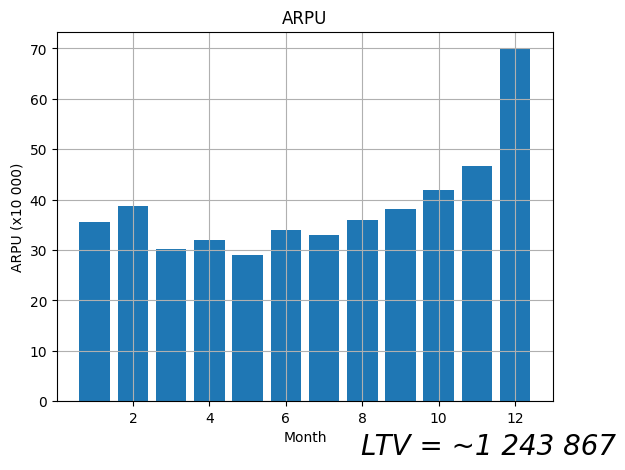

In [32]:
plt.bar(arpu.MonthNumber[:-1], arpu[:-1].ARPU/10000) #last mont is not whole
plt.title('ARPU')
plt.xlabel('Month')
plt.ylabel('ARPU (x10 000)')
plt.figtext(0.6, 0.0, 'LTV = ~1 243 867', 
            fontsize=20, style='italic')
plt.grid(True)

In [ ]:
conn = sqlite3.connect('online_retail.db')

with open('sql/cogorts_by_country.sql', 'r') as file:
    query_corgots_by_country = file.read()

corgots_by_country = pd.read_sql(query_corgots_by_country, conn)
corgots_by_country.head(10)

,Country,NonAnonymousUsers,AvgOrders,MedianOrders
0,United Kingdom,3950,5.027089,3.0
1,Germany,95,6.347368,3.0
2,France,87,5.264368,3.0
3,Spain,31,3.387097,2.0
4,Belgium,25,4.760000,4.0
5,Switzerland,21,3.380952,2.0
6,Portugal,19,3.684211,2.0
7,Italy,15,3.666667,1.0
8,Finland,12,4.000000,2.0
9,Austria,11,1.727273,1.0


In [29]:
conn = sqlite3.connect('online_retail.db')

with open('sql/cogorts_by_anonymous.sql', 'r') as file:
    query_corgots_by_a = file.read()

corgots_by_a = pd.read_sql(query_corgots_by_a, conn)
print(
    float(
    corgots_by_a['COUNT(InvoiceNo)'].iloc[0]/
 (corgots_by_a['COUNT(InvoiceNo)'].iloc[0]+corgots_by_a['COUNT(InvoiceNo)'].iloc[1])
 )
 )
#0.75 revenue is from authorized users. anonymous ration 
corgots_by_a.head()

0.750733056657114


,is_anonymous,COUNT(InvoiceNo)
0,no,406829
1,yes,135080


In [8]:
conn = sqlite3.connect('online_retail.db')

with open('sql/stocks_analysis.sql', 'r') as file:
    query = file.read()

stocks_analysis = pd.read_sql(query, conn)
stocks_analysis.head()

,StockCode,unit_price,SUM(Quantity),stock_revenue
0,M,38970.00,3361950,1.310152e+11
1,POST,8142.75,7774000,6.330174e+10
2,22423,24.96,26359485,6.579327e+08
3,85123A,5.79,86004416,4.979656e+08
4,85099B,4.13,80570436,3.327559e+08


Text(0, 0.5, 'Revenue(millions)')

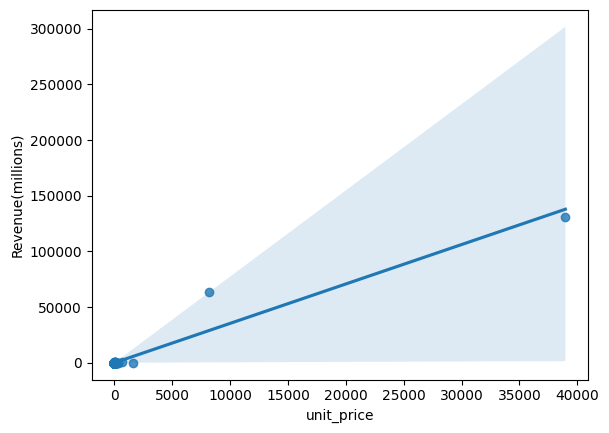

In [ ]:
y = stocks_analysis['stock_revenue']/1e6 #millions

sns.regplot(data=stocks_analysis, x='unit_price', y = y)
plt.ylabel('Revenue(millions)')

In [14]:
unprofitable_stocks = stocks_analysis[stocks_analysis.stock_revenue < 0]
unprofitable_stocks.tail()

,StockCode,unit_price,SUM(Quantity),stock_revenue
3668,23270,1.45,-203327,-294824.15
3669,22618,9.95,-45136,-449103.20
3670,85036C,8.29,-70122,-581311.38
3671,23005,0.42,-2638311,-1108090.62
3672,22617,10.79,-172380,-1859980.20


In [15]:
unprofitable_stocks.to_csv('unprofitable_stocks.csv', index=False)